In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import scipy.signal
import scipy.stats
import pickle
import os
import time

In [2]:
np.set_printoptions(suppress=True)
np.random.seed(3451)

In [3]:
modelo = tf.keras.models.load_model('./Jul_16_00_28_2023/super_model_latpar.h5')
modelo.trainable = False

xrdModel = tf.keras.models.Model(inputs = modelo.inputs[0], outputs = modelo.get_layer('LNGAP000').output, name = 'xrdBranch')

In [4]:
directorio = time.ctime().replace(' ', ':').split(':')[1:]
directorio.pop(-2)
directorio = '_'.join(directorio)

print('directory created:', directorio)    
os.system('mkdir ' + directorio)

directory created: Oct_15_12_53_2024


0

### 1. Inorganic diffraction patterns

In [5]:
x0050 = np.load('C:/iG_2024/inorgMat/xset_0050.npy')
df = pd.read_csv('C:/iG_2024/inorgMat/materials_info.csv')

cond0 = np.argwhere(x0050.max(axis=(1,2)) >= 1e2)[:,0]
x0050 = x0050[cond0]

df = df.take(cond0).reset_index(drop=True)

x0050 = x0050/x0050.max(axis=(1,2), keepdims=True)

peaks = list()
for xrd in range(x0050.shape[0]):
    
    peaks += [scipy.signal.find_peaks(x0050[xrd,:,0], height = 0.05)[0].shape[0]]

df['numpeaks'] = peaks

cond1 = [i for i in df[df['numpeaks'].values >= 6].index]

x0050 = x0050[cond1]
df = df.take(cond1).reset_index(drop=True)

x0100 = np.load('C:/iG_2024/inorgMat/xset_0100.npy')
x0100 = x0100[cond0]
x0100 = x0100[cond1]
x0100 = x0100/x0100.max(axis=(1,2), keepdims=True)

x0250 = np.load('C:/iG_2024/inorgMat/xset_0250.npy')
x0250 = x0250[cond0]
x0250 = x0250[cond1]
x0250 = x0250/x0250.max(axis=(1,2), keepdims=True)

xmacro = np.load('C:/iG_2024/inorgMat/xset_macro.npy')
xmacro = xmacro[cond0]
xmacro = xmacro[cond1]
xmacro = xmacro/xmacro.max(axis=(1,2), keepdims=True)

cs = dict()
for n in range(1,231):
    
    if n <= 2: cs[n]  = 0;
    elif 2 < n <=15: cs[n] = 1;
    elif 15 < n <=74: cs[n] = 2;
    elif 74 < n <=142: cs[n] = 3;
    elif 142 < n <=167: cs[n] = 4;
    elif 167 < n <=194: cs[n] = 5;
    elif 194 < n <=230: cs[n] = 6;
        
df['cs'] = [cs[sg] for sg in df.sg.values]

### OUTPUT DATA CREATION ###

latpars = df[['a','b','c','alpha','beta', 'gamma']].values
y = np.zeros(latpars.shape)
for row in range(latpars.shape[0]):
    
    abc = latpars[row,:3]
    angles = latpars[row,3:]
    sidx = np.argsort(abc)
    sabc = abc[sidx]
    sangles = angles[sidx]
    
    y[row,:3] = sabc
    y[row,3:] = np.cos(np.deg2rad(sangles))
    
idxtest = np.random.choice(np.arange(x0050.shape[0]), size = int(0.2*x0050.shape[0]), replace=False)
idxtraval = np.setdiff1d(np.arange(x0050.shape[0]), idxtest)

diccio_means = dict()
diccio_std = dict()
for n, xsize in enumerate([x0050, x0100, x0250, xmacro]):
    
    if n == 0:
        x = xrdModel.predict(xsize)
        xmean = x.mean(axis=0, keepdims=True)
        xstd = x.std(axis=0, keepdims=True)
        x = (x - xmean)/xstd
        diccio_means[n] = xmean
        diccio_std[n] = xstd
        
        xtraval = x[idxtraval]
        xtest = x[idxtest]
        ytraval = y[idxtraval]
        ytest = y[idxtest]
        
    else:
        xtemp = xrdModel.predict(xsize)
        xtemp = (xtemp - xtemp.mean(axis=0, keepdims=True))/xtemp.std(axis=0, keepdims=True)
        
        xtraval = np.concatenate((xtraval, xtemp[idxtraval]), axis=0)
        xtest = np.concatenate((xtest, xtemp[idxtest]), axis=0)
        ytraval = np.concatenate((ytraval, y[idxtraval]), axis=0)
        ytest = np.concatenate((ytest, y[idxtest]), axis=0)

dftraval = df.iloc[idxtraval].reset_index(drop=True)
dftest = df.iloc[idxtest].reset_index(drop=True)

dftraval.to_csv(directorio + '/' + 'dftraval_inorg.csv', index=None)
dftest.to_csv(directorio + '/' + 'dftest_inorg.csv', index=None)

817/817 [==============================] - 16s 19ms/step


In [6]:
feature_standarisation = dict()
feature_standarisation['means'] = diccio_means
feature_standarisation['stds'] = diccio_std

In [7]:
np.save(directorio + '/' + 'featstd', feature_standarisation)

In [8]:
ortho_cs = scipy.stats.ortho_group.rvs(16, random_state = 3451)
ortho_sg = scipy.stats.ortho_group.rvs(230, random_state = 3451)

In [9]:
np.save(directorio + '/' + 'inorg_ortho_cs', ortho_cs)
np.save(directorio + '/' + 'inorg_ortho_sg', ortho_sg)

In [10]:
ortho_cstraval = np.concatenate([ortho_cs[df.cs[idxtraval]]]*4, axis=0)
ortho_cstest = np.concatenate([ortho_cs[df.cs[idxtest]]]*4, axis=0)

ortho_sgtraval = np.concatenate([ortho_sg[df.sg[idxtraval]-1]]*4, axis=0)
ortho_sgtest = np.concatenate([ortho_sg[df.sg[idxtest]-1]]*4, axis=0)

In [11]:
diccio_ptest = dict()
diccio_models = dict()
diccio_ptest['ytest'] = ytest

### 2. Baseline: Linear regression

#### 2.1 Just diffraction patterns

In [12]:
from sklearn.linear_model import LinearRegression, Ridge

In [13]:
lr = LinearRegression()
lr.fit(xtraval, ytraval)

LinearRegression()

In [14]:
ptest = lr.predict(xtest)
print(((ytest - ptest)**2).mean(axis=0)**0.5)
print(abs(ytest - ptest).mean(axis=0))

diccio_ptest['lr-xrd'] = ptest
diccio_models['lr-xrd'] = lr

print('RMSE unit-vectors:', ((ytest[:,:3] - ptest[:,:3])**2).mean()**0.5)
print('MAE unit-vectors:', abs(ytest[:,:3] - ptest[:,:3]).mean())
print('MAPE unit-vectors:', 100*abs((ytest[:,:3] - ptest[:,:3])/ytest[:,:3]).mean())

[1.80269673 2.03263299 3.24014849 0.14889186 0.07811681 0.16606722]
[1.30554557 1.52797822 2.38924842 0.09782506 0.03313745 0.11707134]
RMSE unit-vectors: 2.4413025602227156
MAE unit-vectors: 1.7409240721501746
MAPE unit-vectors: 20.905277013912247


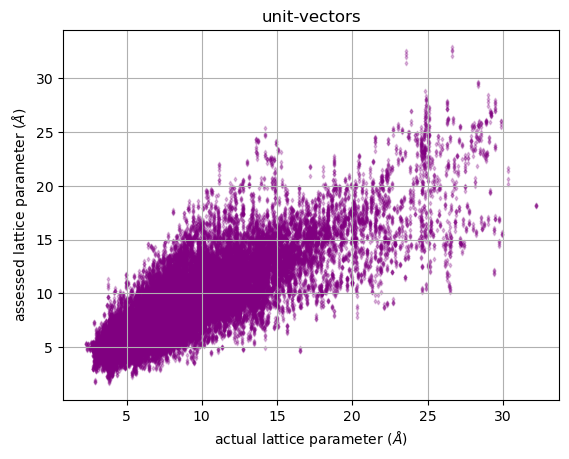

In [15]:
plt.figure()
plt.title(r'unit-vectors')
plt.scatter(ytest[:,:3], ptest[:,:3], color='purple', marker = 'd', s = 5, alpha = 0.25)
plt.xlabel(r'actual lattice parameter ($\AA$)')
plt.ylabel(r'assessed lattice parameter ($\AA$)')
plt.grid()
plt.savefig(directorio + '/' + 'lr-xrd.png', format='png', dpi=1200, transparent=True)
plt.show()

#### 2.2 With crystal system encoding

In [16]:
cstraval = np.concatenate((xtraval, ortho_cstraval), axis = -1)
cstest = np.concatenate((xtest, ortho_cstest), axis = -1)

In [17]:
lrcs = LinearRegression().fit(cstraval, ytraval)

In [18]:
ptest = lrcs.predict(cstest)
print(((ytest - ptest)**2).mean(axis=0)**0.5)
print(abs(ytest - ptest).mean(axis=0))

diccio_ptest['lr-cs'] = ptest
diccio_models['lr-cs'] = lrcs

print('RMSE unit-vectors:', ((ytest[:,:3] - ptest[:,:3])**2).mean()**0.5)
print('MAE unit-vectors:', abs(ytest[:,:3] - ptest[:,:3]).mean())
print('MAPE unit-vectors:', 100*abs((ytest[:,:3] - ptest[:,:3])/ytest[:,:3]).mean())

[1.45870951 1.82686383 2.93939876 0.13359601 0.07648672 0.12952025]
[1.04905046 1.33096956 2.17139762 0.08768609 0.03353299 0.08391875]
RMSE unit-vectors: 2.1683580521591463
MAE unit-vectors: 1.5171392098289185
MAPE unit-vectors: 18.027780697044644


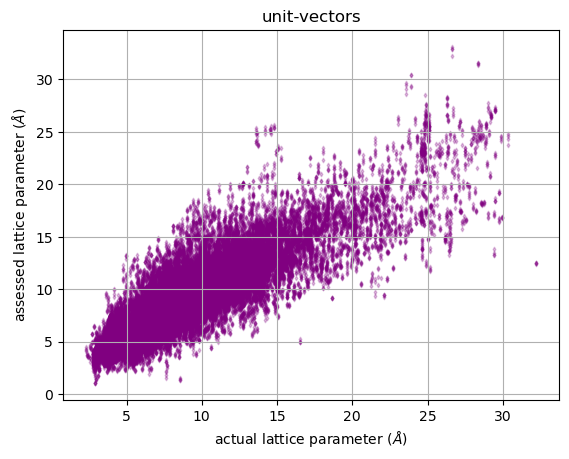

In [19]:
plt.figure()
plt.title(r'unit-vectors')
plt.scatter(ytest[:,:3], ptest[:,:3], color='purple', marker = 'd', s = 5, alpha = 0.25)
plt.xlabel(r'actual lattice parameter ($\AA$)')
plt.ylabel(r'assessed lattice parameter ($\AA$)')
plt.grid()
plt.savefig(directorio + '/' + 'lr-cs.png', format='png', dpi=1200, transparent=True)
plt.show()

#### 2.2 With space group encoding

In [20]:
sgtraval = np.concatenate((xtraval, ortho_sgtraval), axis = -1)
sgtest = np.concatenate((xtest, ortho_sgtest), axis = -1)

In [21]:
lrsg = Ridge(alpha=1e-2).fit(sgtraval, ytraval)

In [22]:
ptest = lrsg.predict(sgtest)
print(((ytest - ptest)**2).mean(axis=0)**0.5)
print(abs(ytest - ptest).mean(axis=0))

diccio_ptest['lr-sg'] = ptest
diccio_models['lr-sg'] = lrsg

print('RMSE unit-vectors:', ((ytest[:,:3] - ptest[:,:3])**2).mean()**0.5)
print('MAE unit-vectors:', abs(ytest[:,:3] - ptest[:,:3]).mean())
print('MAPE unit-vectors:', 100*abs((ytest[:,:3] - ptest[:,:3])/ytest[:,:3]).mean())

[1.14381716 1.41907741 2.11091479 0.12489233 0.07665153 0.12145459]
[0.83078744 1.00019794 1.44070702 0.07538826 0.03400719 0.07147756]
RMSE unit-vectors: 1.6101821477376366
MAE unit-vectors: 1.090564131578147
MAPE unit-vectors: 13.108547796207311


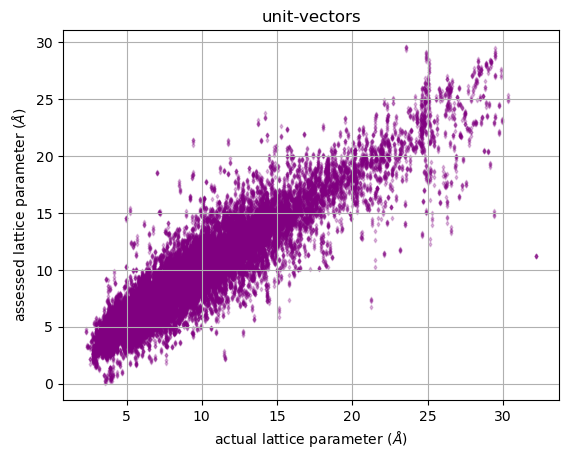

In [23]:
plt.figure()
plt.title(r'unit-vectors')
plt.scatter(ytest[:,:3], ptest[:,:3], color='purple', marker = 'd', s = 5, alpha = 0.25)
plt.xlabel(r'actual lattice parameter ($\AA$)')
plt.ylabel(r'assessed lattice parameter ($\AA$)')
plt.grid()
plt.savefig(directorio + '/' + 'lr-sg.png', format='png', dpi=1200, transparent=True)
plt.show()

### 3. NN models

In [24]:
def create_mlp(features = int, multiples = list, dropout = 0, name= 'multilayer_nn'):
    input_layer = tf.keras.Input((features))

    for n, hl in enumerate(multiples):

        if n == 0: x = tf.keras.layers.Dense(hl*features)(input_layer)
        else: x = tf.keras.layers.Dense(hl*features)(x)

        x = tf.keras.layers.LayerNormalization()(x)

        if n != len(multiples) -1:
            x = tf.keras.layers.LeakyReLU(0.15)(x)
            x = tf.keras.layers.Dropout(dropout)(x)

    xs = tf.keras.layers.Dense(multiples[-1]*features)(input_layer)
    xs = tf.keras.layers.LayerNormalization()(xs)

    x = tf.keras.layers.Add()([x, xs])
    x = tf.keras.layers.LeakyReLU(0.5)(x)
    x = tf.keras.layers.Dropout(dropout)(x)

    x = tf.keras.layers.Dense(6)(x)

    return tf.keras.models.Model(inputs=input_layer, outputs=x, name=name)

#### 3.2 Only diffraction patterns

In [25]:
features = xtraval.shape[-1]
multiples = [2,1]
modelo_xrd = create_mlp(features = features, multiples = multiples, dropout = 0.5, name='mlp_xrd')
modelo_xrd.summary()

modelo_xrd.compile(loss='logcosh', metrics =['MeanSquaredError'],
                      optimizer=tf.keras.optimizers.Adamax(beta_1=0.9, beta_2=0.999, lr=1e-3, decay=1e-8,))

epochs = 50
batch_size = 256
verbose=1
saveas = 'inorg_model_xrd'

modelCheckpoint=tf.keras.callbacks.ModelCheckpoint(str(saveas)+'.h5', monitor='val_loss', verbose=0, save_best_only=True, mode='auto')
history = tf.keras.callbacks.History()
data = modelo_xrd.fit(xtraval,ytraval, validation_data=(xtest,ytest), epochs=epochs,batch_size=batch_size, callbacks=[modelCheckpoint,history],shuffle=True, verbose=verbose)

Model: "mlp_xrd"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 384)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 768)          295680      ['input_1[0][0]']                
                                                                                                  
 layer_normalization (LayerNorm  (None, 768)         1536        ['dense[0][0]']                  
 alization)                                                                                       
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 768)          0           ['layer_normalization[0][0]

C:\Users\igofo\anaconda3\envs\tf\lib\site-packages\keras\optimizers\optimizer_v2\adamax.py:99: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/50
327/327 [==============================] - 6s 14ms/step - loss: 0.9653 - mean_squared_error: 5.2926 - val_loss: 0.6077 - val_mean_squared_error: 3.0532
Epoch 2/50
327/327 [==============================] - 4s 12ms/step - loss: 0.6615 - mean_squared_error: 3.4650 - val_loss: 0.5480 - val_mean_squared_error: 2.7526
Epoch 3/50
327/327 [==============================] - 4s 12ms/step - loss: 0.5916 - mean_squared_error: 3.1024 - val_loss: 0.5072 - val_mean_squared_error: 2.5776
Epoch 4/50
327/327 [==============================] - 4s 12ms/step - loss: 0.5535 - mean_squared_error: 2.8617 - val_loss: 0.4987 - val_mean_squared_error: 2.4818
Epoch 5/50
327/327 [==============================] - 4s 12ms/step - loss: 0.5277 - mean_squared_error: 2.6909 - val_loss: 0.4804 - val_mean_squared_error: 2.3992
Epoch 6/50
327/327 [==============================] - 4s 12ms/step - loss: 0.5062 - mean_squared_error: 2.5466 - val_loss: 0.4587 - val_mean_squared_error: 2.2765
Epoch 7/50
327/327 [==

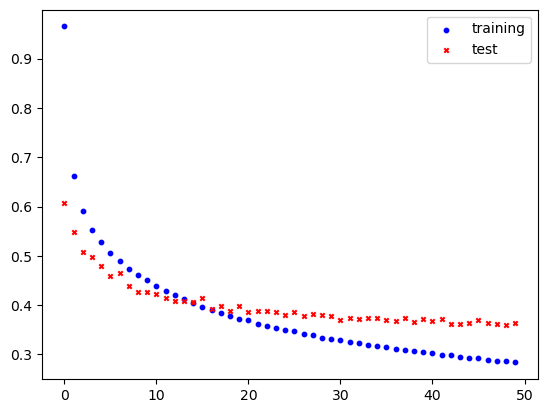

In [26]:
loss_log = data.history['loss']
val_loss_log = data.history['val_loss']
mat = np.vstack((loss_log, val_loss_log))
dataframe1 = pd.DataFrame(data=mat.T)
dataframe1.to_csv(directorio + '/' + str(saveas)+'.csv', sep=',', header=False, float_format='%.7f', index=False)

plt.figure()
plt.scatter(np.arange(mat.T.shape[0]), mat.T[:,0], color = 'blue', marker='o', label='training', s=10)
plt.scatter(np.arange(mat.T.shape[0]), mat.T[:,1], color = 'red', marker='x', label='test', s=10)
plt.legend(loc='best')
plt.show()

654/654 [==============================] - 4s 6ms/step


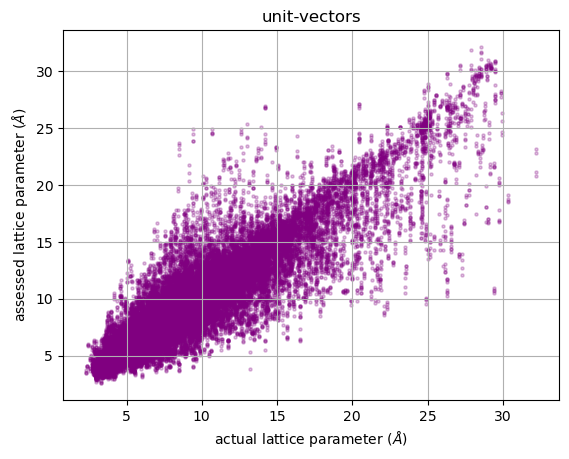

In [27]:
ptestnn = modelo_xrd.predict(xtest)
plt.figure()
plt.title(r'unit-vectors')
plt.scatter(ytest[:,:3], ptestnn[:,:3], s=5, color='purple', alpha=0.25)
plt.xlabel(r'actual lattice parameter ($\AA$)')
plt.ylabel(r'assessed lattice parameter ($\AA$)')
plt.grid()
plt.savefig(directorio + '/' + 'ann-xrd.png', format='png', dpi=1200, transparent=True)
plt.show()

In [28]:
rmse = ((ptestnn[:,:3] - ytest[:,:3])**2).mean()**0.5

In [29]:
print('RMSE unit-vectors:', rmse)
print(((ptestnn- ytest)**2).mean(axis=0)**0.5)
print('MAPE unit-vectors:', 100*abs((ytest[:,:3] - ptestnn[:,:3])/ytest[:,:3]).mean())

RMSE unit-vectors: 1.8504601752443124
[1.24572915 1.58744921 2.49013503 0.14799277 0.079799   0.16536824]
MAPE unit-vectors: 13.438180808562825


In [30]:
diccio_models['ann-xrd'] = modelo_xrd
diccio_ptest['ann-xrd'] = ptestnn

#### 3.3 With crystal system encoding

In [31]:
features = cstraval.shape[-1]
multiples = [2,1]
modelo_cs = create_mlp(features = features, multiples = multiples, dropout = 0.5, name='mlp_cs')
modelo_cs.summary()

modelo_cs.compile(loss='logcosh', metrics =['MeanSquaredError'],
                      optimizer=tf.keras.optimizers.Adamax(beta_1=0.9, beta_2=0.999, lr=1e-3, decay=1e-8,))

epochs = 50
batch_size = 256
verbose=1
saveas = 'inorg_model_crystal_system'

modelCheckpoint=tf.keras.callbacks.ModelCheckpoint(str(saveas)+'.h5', monitor='val_loss', verbose=0, save_best_only=True, mode='auto')
history = tf.keras.callbacks.History()
data = modelo_cs.fit(cstraval,ytraval, validation_data=(cstest,ytest), epochs=epochs,batch_size=batch_size, callbacks=[modelCheckpoint,history],shuffle=True, verbose=verbose)

Model: "mlp_cs"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 400)]        0           []                               
                                                                                                  
 dense_4 (Dense)                (None, 800)          320800      ['input_2[0][0]']                
                                                                                                  
 layer_normalization_3 (LayerNo  (None, 800)         1600        ['dense_4[0][0]']                
 rmalization)                                                                                     
                                                                                                  
 leaky_re_lu_2 (LeakyReLU)      (None, 800)          0           ['layer_normalization_3[0][0

327/327 [==============================] - 4s 11ms/step - loss: 0.2695 - mean_squared_error: 1.0249 - val_loss: 0.2828 - val_mean_squared_error: 1.2742
Epoch 30/50
327/327 [==============================] - 4s 12ms/step - loss: 0.2662 - mean_squared_error: 1.0076 - val_loss: 0.2827 - val_mean_squared_error: 1.2534
Epoch 31/50
327/327 [==============================] - 4s 12ms/step - loss: 0.2630 - mean_squared_error: 0.9915 - val_loss: 0.2845 - val_mean_squared_error: 1.2809
Epoch 32/50
327/327 [==============================] - 4s 12ms/step - loss: 0.2607 - mean_squared_error: 0.9796 - val_loss: 0.2806 - val_mean_squared_error: 1.2534
Epoch 33/50
327/327 [==============================] - 3s 11ms/step - loss: 0.2591 - mean_squared_error: 0.9691 - val_loss: 0.2791 - val_mean_squared_error: 1.2431
Epoch 34/50
327/327 [==============================] - 4s 12ms/step - loss: 0.2562 - mean_squared_error: 0.9545 - val_loss: 0.2750 - val_mean_squared_error: 1.2373
Epoch 35/50
327/327 [=======

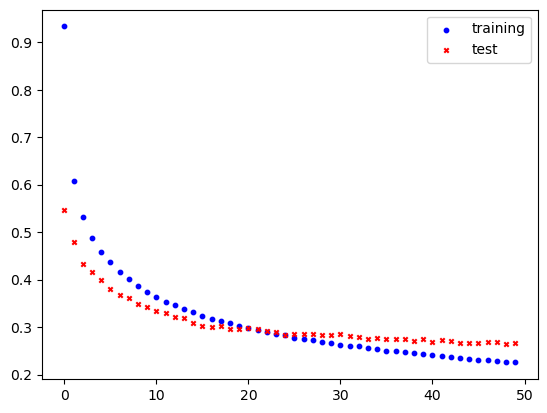

In [32]:
loss_log = data.history['loss']
val_loss_log = data.history['val_loss']
mat = np.vstack((loss_log, val_loss_log))
dataframe1 = pd.DataFrame(data=mat.T)
dataframe1.to_csv(directorio + '/' + str(saveas)+'.csv', sep=',', header=False, float_format='%.7f', index=False)

plt.figure()
plt.scatter(np.arange(mat.T.shape[0]), mat.T[:,0], color = 'blue', marker='o', label='training', s=10)
plt.scatter(np.arange(mat.T.shape[0]), mat.T[:,1], color = 'red', marker='x', label='test', s=10)
plt.legend(loc='best')
plt.show()

654/654 [==============================] - 4s 6ms/step


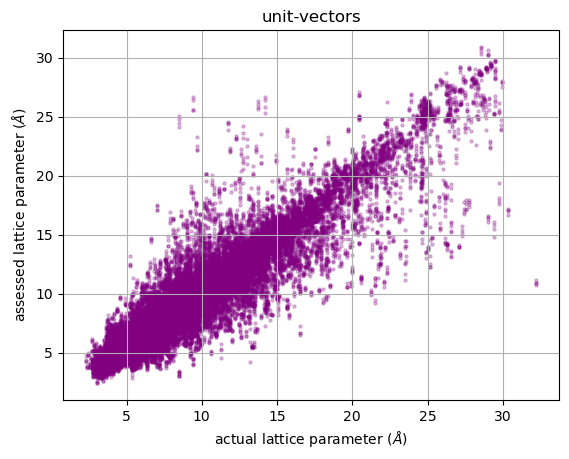

In [33]:
ptestnn = modelo_cs.predict(cstest)
plt.figure()
plt.title(r'unit-vectors')
plt.scatter(ytest[:,:3], ptestnn[:,:3], s=5, color='purple', alpha=0.25)
plt.xlabel(r'actual lattice parameter ($\AA$)')
plt.ylabel(r'assessed lattice parameter ($\AA$)')
plt.grid()
plt.savefig(directorio + '/' + 'ann-cs.png', format='png', dpi=1200, transparent=True)
plt.show()

In [34]:
rmse = ((ptestnn[:,:3] - ytest[:,:3])**2).mean()**0.5

In [35]:
print('RMSE unit-vectors:', rmse)
print(((ptestnn- ytest)**2).mean(axis=0)**0.5)
print('MAPE unit-vectors:', 100*abs((ytest[:,:3] - ptestnn[:,:3])/ytest[:,:3]).mean())

RMSE unit-vectors: 1.5430441189604922
[1.02198636 1.34621566 2.07031465 0.13032262 0.07995618 0.12868603]
MAPE unit-vectors: 10.711273008835057


In [36]:
diccio_models['ann-cs'] = modelo_cs
diccio_ptest['ann-cs'] = ptestnn

#### 3.3 With space group encoding

In [37]:
features = sgtraval.shape[-1]
multiples = [2,1]
modelo_sg = create_mlp(features = features, multiples = multiples, dropout = 0.5, name='mlp_sg')
modelo_sg.summary()

modelo_sg.compile(loss='logcosh', metrics =['MeanSquaredError'],
                      optimizer=tf.keras.optimizers.Adamax(beta_1=0.9, beta_2=0.999, lr=1e-3, decay=1e-8,))

epochs = 50
batch_size = 256
verbose=1
saveas = 'inorg_model_space_group'

modelCheckpoint=tf.keras.callbacks.ModelCheckpoint(str(saveas)+'.h5', monitor='val_loss', verbose=0, save_best_only=True, mode='auto')
history = tf.keras.callbacks.History()
data = modelo_sg.fit(sgtraval,ytraval, validation_data=(sgtest,ytest), epochs=epochs,batch_size=batch_size, callbacks=[modelCheckpoint,history],shuffle=True, verbose=verbose)

Model: "mlp_sg"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 614)]        0           []                               
                                                                                                  
 dense_8 (Dense)                (None, 1228)         755220      ['input_3[0][0]']                
                                                                                                  
 layer_normalization_6 (LayerNo  (None, 1228)        2456        ['dense_8[0][0]']                
 rmalization)                                                                                     
                                                                                                  
 leaky_re_lu_4 (LeakyReLU)      (None, 1228)         0           ['layer_normalization_6[0][0

327/327 [==============================] - 4s 11ms/step - loss: 0.1621 - mean_squared_error: 0.5266 - val_loss: 0.1770 - val_mean_squared_error: 0.7068
Epoch 30/50
327/327 [==============================] - 3s 10ms/step - loss: 0.1601 - mean_squared_error: 0.5178 - val_loss: 0.1739 - val_mean_squared_error: 0.7019
Epoch 31/50
327/327 [==============================] - 4s 11ms/step - loss: 0.1585 - mean_squared_error: 0.5099 - val_loss: 0.1724 - val_mean_squared_error: 0.6967
Epoch 32/50
327/327 [==============================] - 4s 11ms/step - loss: 0.1569 - mean_squared_error: 0.5052 - val_loss: 0.1715 - val_mean_squared_error: 0.6932
Epoch 33/50
327/327 [==============================] - 4s 11ms/step - loss: 0.1547 - mean_squared_error: 0.4962 - val_loss: 0.1741 - val_mean_squared_error: 0.6992
Epoch 34/50
327/327 [==============================] - 4s 11ms/step - loss: 0.1529 - mean_squared_error: 0.4853 - val_loss: 0.1716 - val_mean_squared_error: 0.6924
Epoch 35/50
327/327 [=======

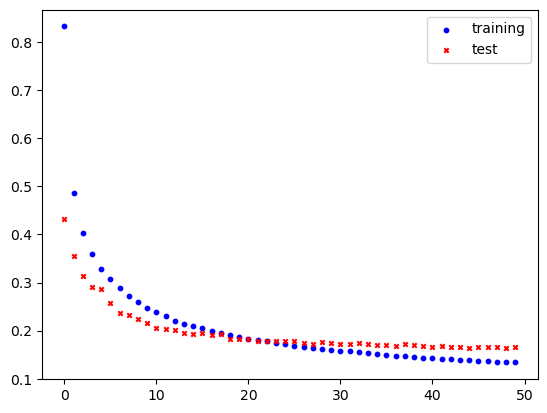

In [38]:
loss_log = data.history['loss']
val_loss_log = data.history['val_loss']
mat = np.vstack((loss_log, val_loss_log))
dataframe1 = pd.DataFrame(data=mat.T)
dataframe1.to_csv(directorio + '/' + str(saveas)+'.csv', sep=',', header=False, float_format='%.7f', index=False)

plt.figure()
plt.scatter(np.arange(mat.T.shape[0]), mat.T[:,0], color = 'blue', marker='o', label='training', s=10)
plt.scatter(np.arange(mat.T.shape[0]), mat.T[:,1], color = 'red', marker='x', label='test', s=10)
plt.legend(loc='best')
plt.show()

654/654 [==============================] - 4s 7ms/step


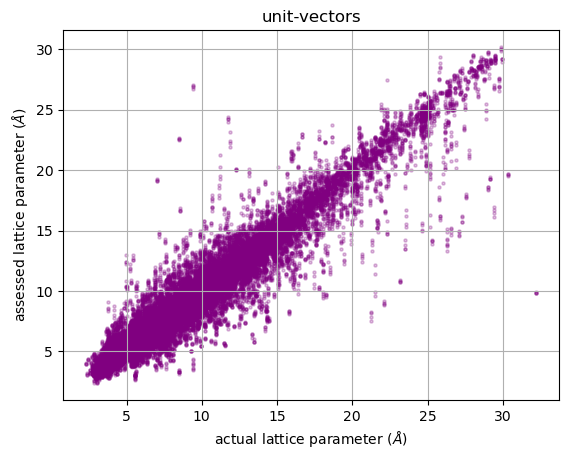

In [39]:
ptestnn = modelo_sg.predict(sgtest)
plt.figure()
plt.title(r'unit-vectors')
plt.scatter(ytest[:,:3], ptestnn[:,:3], s=5, color='purple', alpha=0.25)
plt.xlabel(r'actual lattice parameter ($\AA$)')
plt.ylabel(r'assessed lattice parameter ($\AA$)')
plt.grid()
plt.savefig(directorio + '/' + 'ann-sg.png', format='png', dpi=1200, transparent=True)
plt.show()

In [40]:
rmse = ((ptestnn[:,:3] - ytest[:,:3])**2).mean()**0.5

In [41]:
print('RMSE unit-vectors:', rmse)
print(((ptestnn- ytest)**2).mean(axis=0)**0.5)
print('MAPE unit-vectors:', 100*abs((ytest[:,:3] - ptestnn[:,:3])/ytest[:,:3]).mean())

RMSE unit-vectors: 1.1520961032882044
[0.8422976  1.03036848 1.48689335 0.12317837 0.07804127 0.12458995]
MAPE unit-vectors: 7.618238210171269


In [42]:
diccio_models['ann-sg'] = modelo_sg
diccio_ptest['ann-sg'] = ptestnn

### 4. Savings

In [43]:
for modelo in diccio_models.keys():

    if modelo.split('-')[0] == 'lr':
        pickle.dump(diccio_models[modelo], open(directorio + '/' + modelo + '.pkl', 'wb'))
    else:
        diccio_models[modelo].save(directorio + '/' + modelo + '.h5')
        
    np.save(directorio + '/' + modelo, diccio_ptest[modelo])